In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("data/global_rates.csv")
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


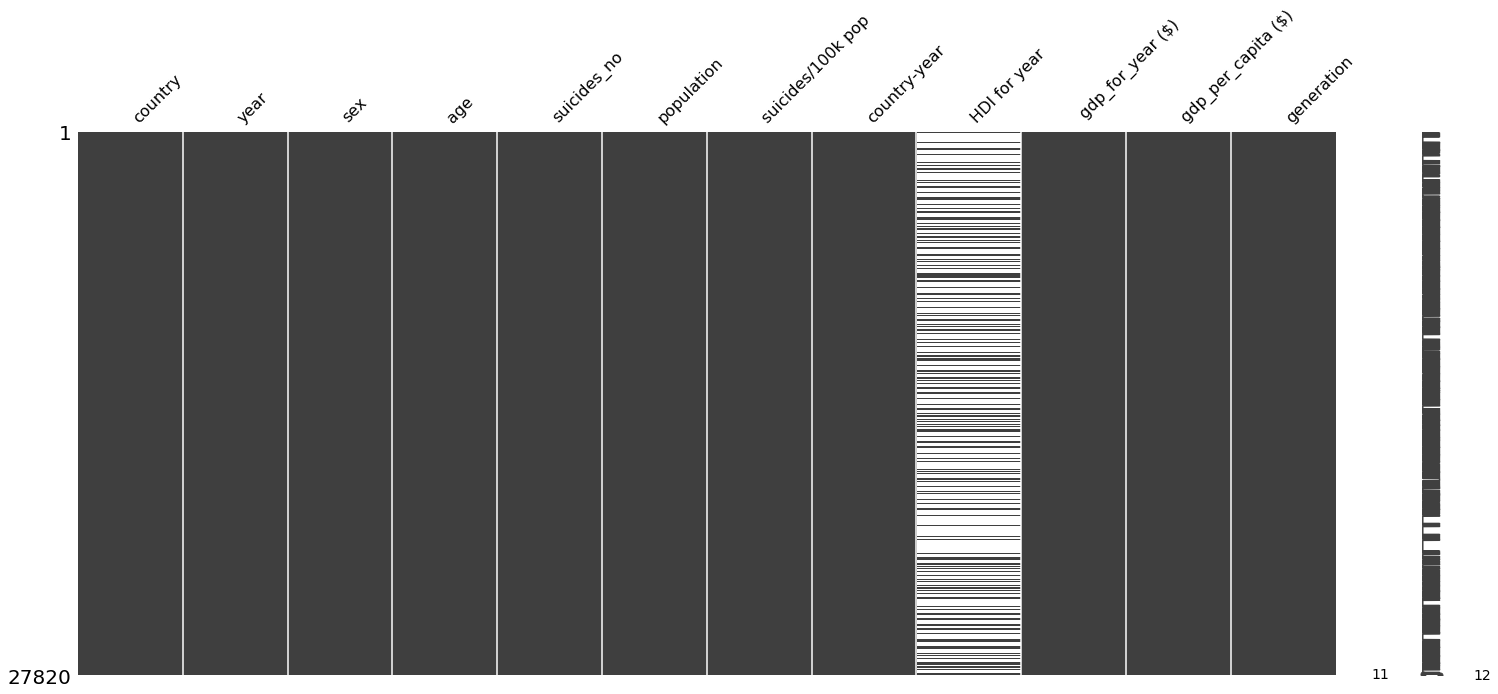

In [4]:
%matplotlib inline 

import missingno as msno

# HDI has a much smaller count than the rest, this may mean it's highly null.
# let's visualize the nullity of our matrix
ax = msno.matrix(df)


HDI does not seem correlated with suicide rate

----------------------------------------------

year                  0.366786
suicides_no           0.151399
population            0.102943
suicides/100k pop     0.074279
HDI for year          1.000000
gdp_per_capita ($)    0.771228
Name: HDI for year, dtype: float64

----------------------------------------------



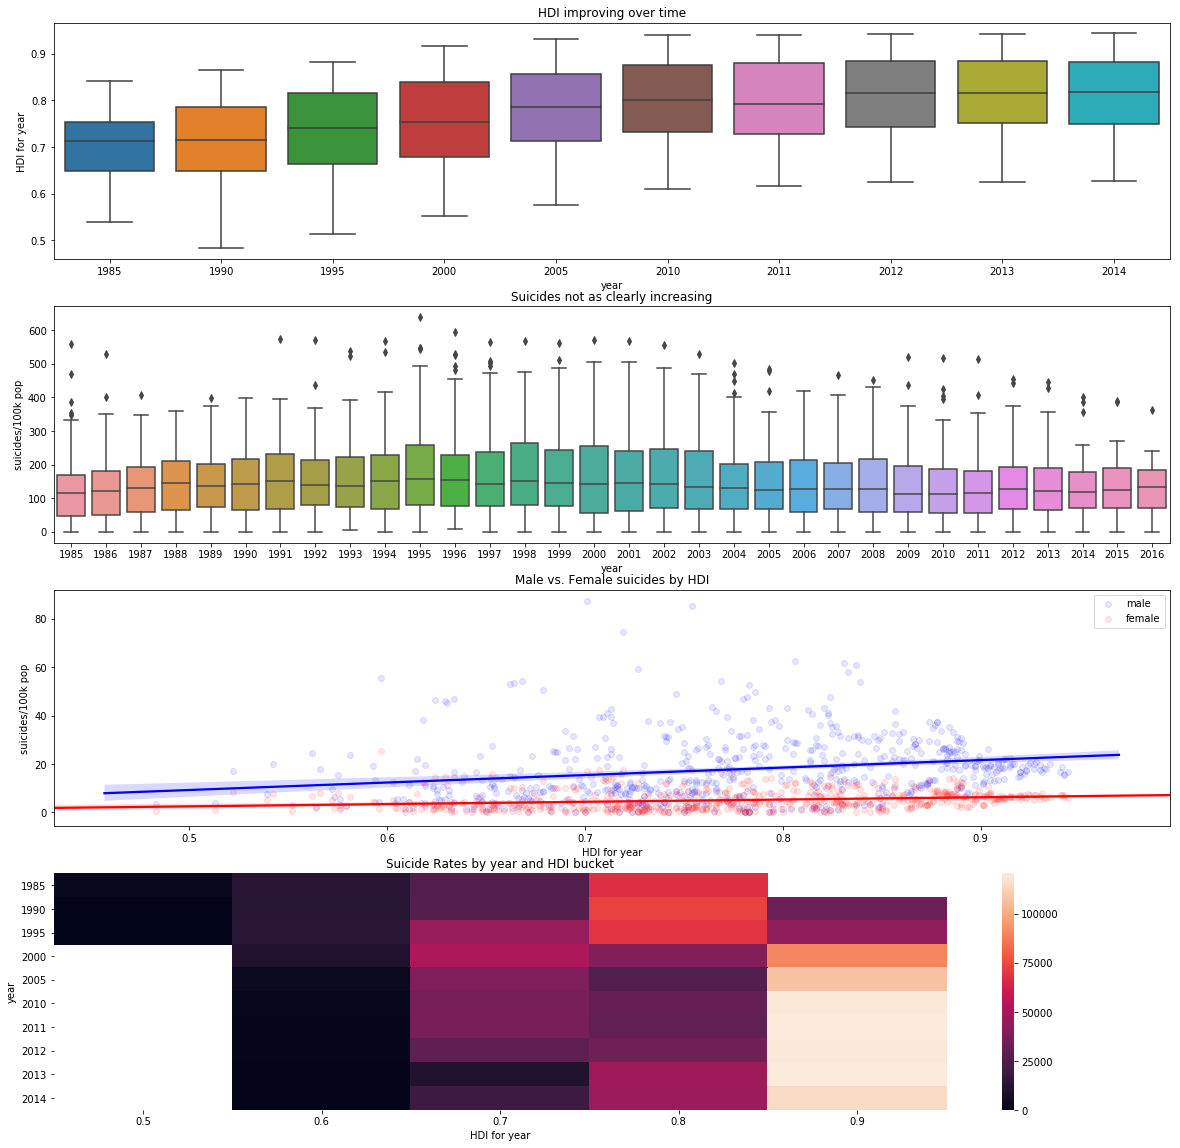

In [168]:
import seaborn as sns
fig, ax=plt.subplots(4,1, figsize=(20, 20))

############################################################
## EXPLORING THE CORRELATION BETWEEN HDI AND SUICIDE RATE ##
############################################################

hdi = df[df['HDI for year'].notnull()]

print('\nHDI does not seem correlated with suicide rate')
print('\n----------------------------------------------\n')
print(hdi.corr()['HDI for year'])
print('\n----------------------------------------------\n')

###########
# BOXPLOT #
###########

sns.boxplot(data=hdi,x='year', y='HDI for year', ax=ax[0]).set_title("HDI improving over time")

# Is suicide rate increasing over time?
df2 = df.groupby(['year','country']).sum().reset_index()
sns.boxplot(data=df2, x='year', y='suicides/100k pop', ax=ax[1]).set_title('Suicides not as clearly increasing')

###########
# SCATTER #
###########

hdi2 = hdi.groupby(['year', 'HDI for year', 'sex']).agg({
    'suicides_no': ['sum'],
    'population': ['sum']
})
hdi2.columns = ['suicides_no', 'population']
hdi2 = hdi2.reset_index()
hdi2['suicides/100k pop'] = hdi2['suicides_no']/hdi2['population']*100000


sns.regplot(data=hdi2[hdi2['sex']=='male'], x='HDI for year', y='suicides/100k pop', ax=ax[2], color='blue', scatter_kws={'alpha':0.1}, label='male').set_title('Male vs. Female suicides by HDI')
sns.regplot(data=hdi2[hdi2['sex']=='female'], x='HDI for year', y='suicides/100k pop', ax=ax[2], color='red', scatter_kws={'alpha':0.1}, label='female')
ax[2].legend(loc="best")


###########
# HEATMAP #
###########

hdi['HDI for year'] = hdi['HDI for year'].apply(lambda x: round(x,1))

hdi = hdi.groupby(['year', 'HDI for year']).agg({
    'suicides_no': ['sum'],
    'population': ['sum']
})

hdi.columns = ['suicides_no', 'population']
hdi['suicides/100k pop'] = hdi['suicides_no']/hdi['population']*100000
hdi = hdi.reset_index()

txt = sns.heatmap(data=hdi.pivot(index='year', columns='HDI for year',values='suicides_no'), ax=ax[3]).set_title('Suicide Rates by year and HDI bucket')


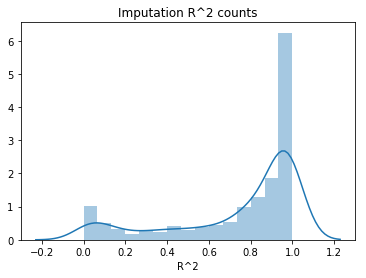

In [169]:
df2 = df.groupby(
    ['sex','country','age','year']
).first()[
    ['suicides_no','population']
].unstack().transpose()

#####################
# Impute Population #
#####################

# Impute population with regression per group defined by sex, age, and country
# Population Growth formula --> P = P_o * e^rt
# Perform a linear regression with ln of the numbers

from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

pop_scores = []

def impute_pop(population_df):
    
    # don't need to impute if no missing values
    if population_df.isna().sum() == 0:
        return population_df
    
    # Regression based on the non missing values
    y_train = population_df.dropna()
    reg = LinearRegression().fit(pd.DataFrame(y_train.index),np.log(y_train))
    
    # Side affect to plot R^2's
    pop_scores.append(reg.score(pd.DataFrame(y_train.index),np.log(y_train)))
    
    # impute
    pop_df_imp = population_df.copy()
    pop_df_imp[pop_df_imp.isna()] = np.exp(reg.predict(pd.DataFrame(pop_df_imp[pop_df_imp.isna()].index)))
    return pop_df_imp
    

for sex, country, age in df2.loc['population']:
    y = df2.loc['population'][sex, country, age]
    df2.loc['population'][sex, country, age] = impute_pop(y)

# plot distribution of R^2 values from this imputation
ax = sns.distplot(pd.Series(pop_scores, name="R^2")).set_title('Imputation R^2 counts')




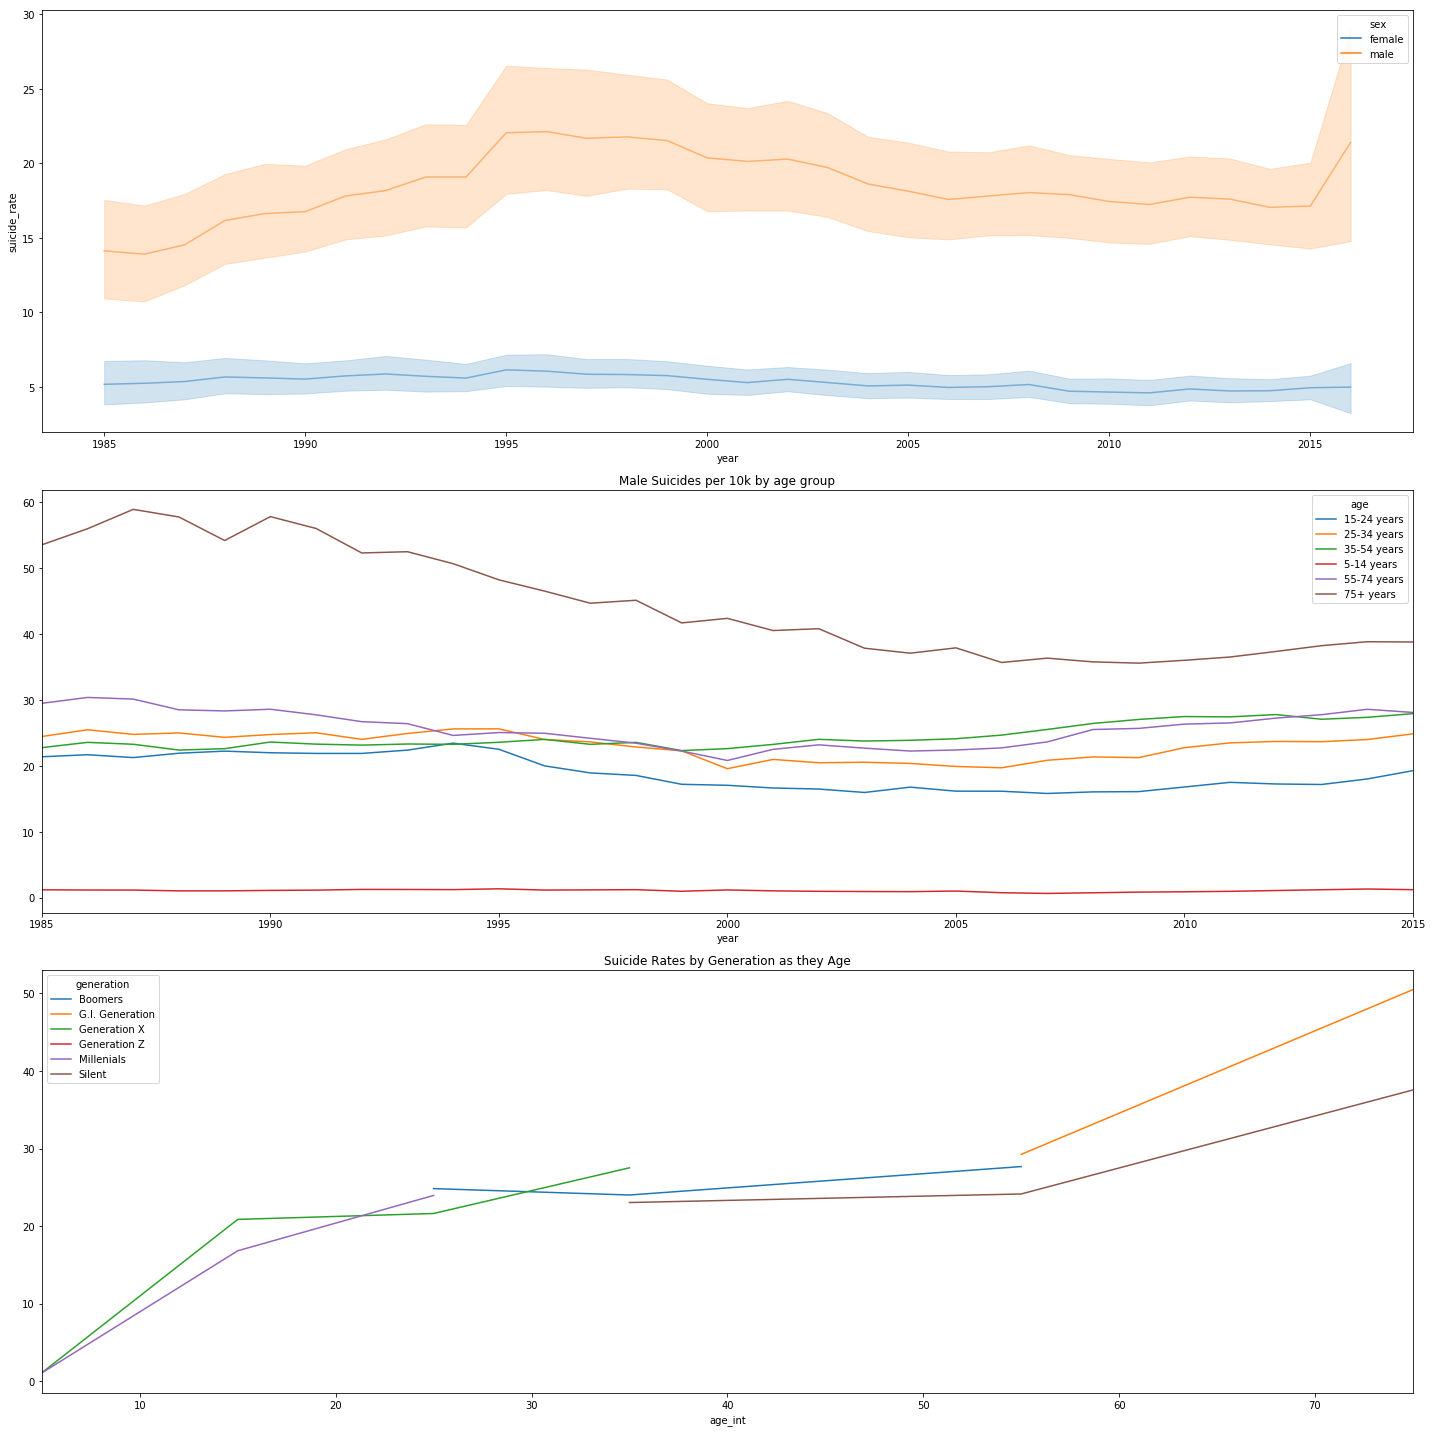

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

# Base Plot: Suicides by gender across all countries
grouped = df.groupby(['country','year','sex']).agg({
        'suicides_no':['sum'],
        'population':['sum']
    }) 

grouped['suicide_rate'] = grouped[('suicides_no','sum')]/grouped[('population','sum')]*100000
grouped = grouped['suicide_rate'].reset_index()
_ = sns.lineplot(data=grouped,x='year',y='suicide_rate',hue='sex', alpha=0.5, ax=axes[0])

# First Plot: Suicides by age group over time
usa = df[df['country']=='United States']
men = usa[usa['sex']=='male']
male_suicides_by_age = men.pivot(index='year',columns='age',values='suicides/100k pop')
male_suicides_by_age.plot(title="Male Suicides per 10k by age group", ax=axes[1])

# Second Plot: Longitudinal View of Suicides by Generation

age_map = {
    '75+ years':75,
    '55-74 years': 55,
    '25-34 years': 25,
    '35-54 years': 35,
    '15-24 years': 15,
    '5-14 years' : 5
}

men.loc[:,'age_int'] = men.loc[:,'age'].apply(lambda x: age_map[x])
grouped_men = men.groupby(['generation','age_int']).agg({
    'suicides_no':['sum'],
    'population':['sum']
})

grouped_men['suicide_rate'] = grouped_men['suicides_no']/grouped_men['population']*100000
ax2 = grouped_men['suicide_rate'].reset_index().pivot(
    index='age_int',columns='generation',values='suicide_rate'
).plot(title="Suicide Rates by Generation as they Age", ax=axes[2])

fig.tight_layout()
plt.show()

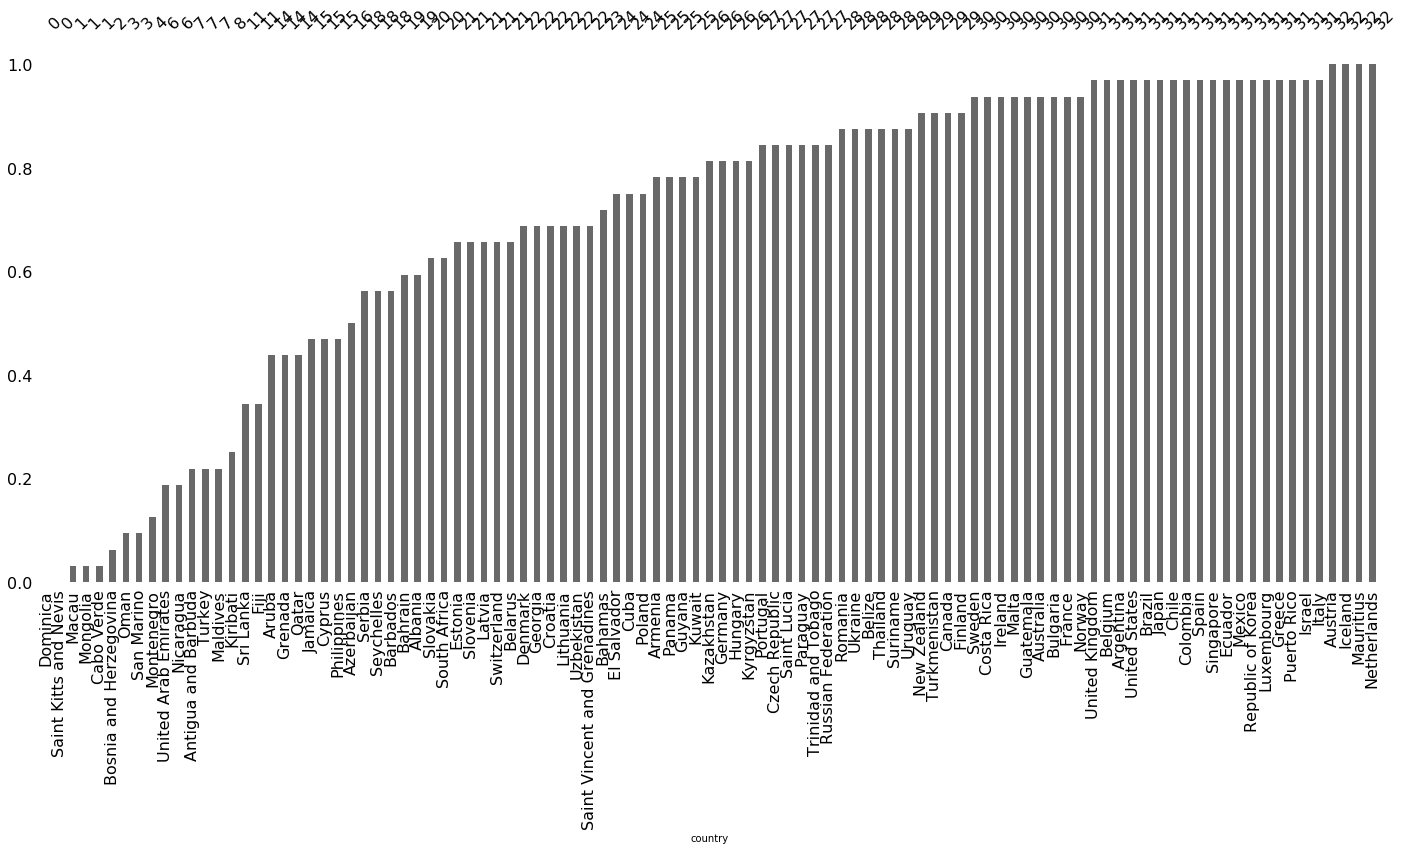

In [41]:
# ###############################
# Number of Suicides Imputation #
#################################

# Remove 0 value for suicide_rate
# It's incredibly hard to believe there are zero suicides

men = grouped[grouped['sex']=='male']
men_pivoted = men.pivot(index='year',columns='country',values='suicide_rate')
men_pivoted = men_pivoted.replace(0,np.NaN)

na_order = men_pivoted.isna().sum().sort_values(ascending=False)
men_pivoted = pd.DataFrame(men_pivoted, columns=na_order.index)
ax = msno.bar(men_pivoted)



                                     

In [22]:
# Linear interpolation

# for country, values in men_pivoted.items():
#     print(country, values)
    
# k-NN 

# Regression

country
Dominica                  32
Saint Kitts and Nevis     32
Macau                     31
Mongolia                  31
Cabo Verde                31
Bosnia and Herzegovina    30
Oman                      29
San Marino                29
Montenegro                28
United Arab Emirates      26
Nicaragua                 26
Antigua and Barbuda       25
Turkey                    25
Maldives                  25
Kiribati                  24
Sri Lanka                 21
Fiji                      21
Aruba                     18
Grenada                   18
Qatar                     18
Jamaica                   17
Cyprus                    17
Philippines               17
Azerbaijan                16
Serbia                    14
Seychelles                14
Barbados                  14
Bahrain                   13
Albania                   13
Slovakia                  12
                          ..
Costa Rica                 2
Ireland                    2
Malta                      2
Guatem

In [8]:
#####################
# Impute Suicide No #
#####################

# Impute suicide_no with kNN, 
# countries with similar baseline population and other variables should have similar suicide rates
# Maybe use some semblence of time trend e.g. slope as variable

import numpy as np

sui_scores = []



def impute_sui(sui_df):
    
    # don't need to impute if no missing values
    if sui_df.isna().sum() == 0:
        return sui_df
    
    # Regression based on the non missing values
    y_train = population_df.dropna()
    reg = LinearRegression().fit(pd.DataFrame(y_train.index),np.log(y_train))
    
    # Side affect to plot R^2's
    pop_scores.append(reg.score(pd.DataFrame(y_train.index),np.log(y_train)))
    
    # impute
    pop_df_imp = population_df.copy()
    pop_df_imp[pop_df_imp.isna()] = np.exp(reg.predict(pd.DataFrame(pop_df_imp[pop_df_imp.isna()].index)))
    return pop_df_imp
    

for sex, country, age in df2.loc['suicides_no']:
    y = population[sex, country, age]
    df2.loc['population'][sex, country, age] = impute_pop(y)

# plot distribution of R^2 values from this imputation
ax = sns.distplot(sui_scores)




NameError: name 'population_df' is not defined

## What are the countries that are anomalies?
We use DBScan to cluster the male and female suicide rates by country (we have 101 timeseries of each!)

First, we need to fill the null values..

In [ ]:
from sklearn.cluster import DBSCAN


men_pivoted
# clustering = DBSCAN(eps=3, min_samples=2).fit(men_pivoted)
# clustering.labels_

In [ ]:
df[df['country']=='Antigua and Barbuda']